In [1]:
import numpy as np
import h5py
from matplotlib import pyplot as plt

In [2]:
train_data = h5py.File('train_catvnoncat.h5', 'r')

In [3]:
train_x = np.array(train_data["train_set_x"][:])
train_y = np.array(train_data["train_set_y"][:])

In [4]:
m_train = train_x.shape[0]

train_x_flattened = train_x.reshape(-1, m_train)
print(train_x_flattened.shape)

(12288, 209)


In [5]:
train_x = train_x_flattened / 255.

In [6]:
train_y = train_y.reshape(1, train_y.shape[0])

In [73]:
print ("train_x's shape: " + str(train_x.shape))
print("train_y's shape: " + str(train_y.shape))

train_x's shape: (12288, 209)
train_y's shape: (1, 209)


## Parameter Initialization

In [8]:
def initialize_parameters(layer_dims):
    parameters = {}
    L = len(layer_dims)
    
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
    
    return parameters    

# Forward Propagation

In [9]:
def sigmoid(Z):
    return (1 / (1 + np.exp(-Z)), Z)

In [10]:
def relu(Z):
    return (np.maximum(0, Z), Z)

In [11]:
def linear_forward(A, W, b):
    Z = np.dot(W, A) + b
    
    cache = (A, W, b)
    
    return Z, cache

In [12]:
def linear_activation_forward(A_prev, W, b, activation):
    if activation == 'relu':
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    
    elif activation == 'sigmoid':
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
        
    cache = (linear_cache, activation_cache)
    
    return A, cache

In [13]:
def deep_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2
    
    for l in range(1, L):
        A_prev = A
        
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], 'relu')
        caches.append(cache)
    
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], 'sigmoid')
    caches.append(cache)
    
    return AL, caches

## Cost computation

In [85]:
def compute_cost(AL, Y):
    m = Y.shape
    
    cost = -(1/m) * (np.dot(Y, np.log(AL).T) + np.dot((1-Y), np.log(1-AL).T))
    cost = np.squeeze(cost)
    
    return cost

# Backpropagation

In [15]:
def sigmoid_deriv(Z):
    return sigmoid(Z)[0] * (1 - sigmoid(Z)[0])

def sigmoid_backward(dA, activation_cache):
    return dA * sigmoid_deriv(activation_cache)

In [16]:
def relu_deriv(Z):
    return Z > 0

def relu_backward(dA, activation_cache):
    return dA * relu_deriv(activation_cache)

In [17]:
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]
    
    dW = (1/m) * np.dot(dZ, A_prev.T)
    db = (1/m) * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T, dZ)
    
    return dA_prev, dW, db

In [18]:
def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
    
    if activation == 'relu':
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == 'sigmoid':
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

In [59]:
def deep_backward(AL, Y, caches):
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    current_cache = caches[L-1]
    dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dAL, current_cache, "sigmoid")
    grads["dA" + str(L-1)] = dA_prev_temp
    grads["dW" + str(L)] = dW_temp
    grads["db" + str(L)] = db_temp
    
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l+1)], current_cache, "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l+1)] = dW_temp
        grads["db" + str(l+1)] = db_temp
        
    return grads

# Update Parameters

In [60]:
def update_parameters(params, grads, learning_rate):
    parameters = params.copy()
    L = len(parameters) // 2
    
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
        
    return parameters

# Buliding the L-layer neural network

In [61]:
layers_dims = [12288, 20, 7, 5, 1]

In [81]:
def L_layer_model(X, Y, layer_dims, learning_rate = 0.0075, num_iterations = 3000):
    costs = []
    
    parameters = initialize_parameters(layers_dims)
    
    for i in range(0, num_iterations):
        AL, caches = deep_forward(X, parameters)
        
        cost = compute_cost(AL, Y)
        
        grads = deep_backward(AL, Y, caches)
        
        parameters = update_parameters(parameters, grads, learning_rate)
        
        if i%100 == 0 or i == num_iterations-1:
            print(f"Cost after iteration {i}: {np.squeeze(cost)}")
            costs.append(cost)
    
    
    return parameters, costs

# Train the model

In [82]:
Parameters, Costs = L_layer_model(train_x, train_y, layers_dims, learning_rate = 0.01)

Cost after iteration 0: 0.6931475988874048
Cost after iteration 100: 0.6740958771233654
Cost after iteration 200: 0.662520116598468
Cost after iteration 300: 0.6554523290635692
Cost after iteration 400: 0.6511119270756448
Cost after iteration 500: 0.6484312180824577
Cost after iteration 600: 0.6467670066863824
Cost after iteration 700: 0.6457292251661968
Cost after iteration 800: 0.6450796367243201
Cost after iteration 900: 0.6446717622080372
Cost after iteration 1000: 0.64441500217289
Cost after iteration 1100: 0.6442530311919518
Cost after iteration 1200: 0.6441506838385265
Cost after iteration 1300: 0.6440859113386007
Cost after iteration 1400: 0.6440448282100932
Cost after iteration 1500: 0.6440188041558915
Cost after iteration 1600: 0.6440022983844276
Cost after iteration 1700: 0.6439918198630776
Cost after iteration 1800: 0.6439851645037237
Cost after iteration 1900: 0.6439809357098407
Cost after iteration 2000: 0.6439782478208872
Cost after iteration 2100: 0.6439765388123198
Cos

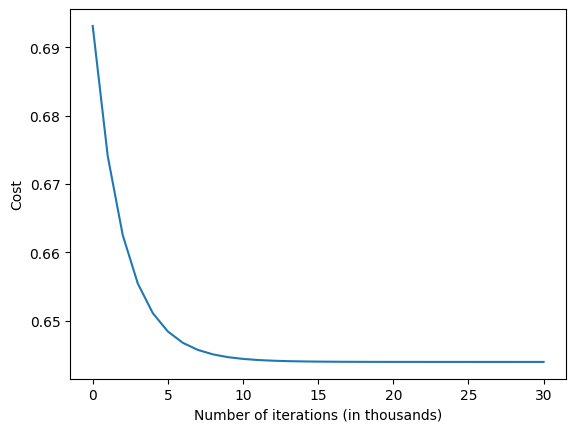

In [104]:
x = [i for i in range(31)]
plt.xlabel("Number of iterations (in thousands)")
plt.ylabel("Cost")
plt.plot(x, Costs)